In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import jax.numpy as jnp
from jax import random
from jax import vmap
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import math

from numpyro.util import enable_x64
enable_x64()

# Load and preprocess data
data = np.loadtxt("data/P3HT_dataset.csv", delimiter=",", skiprows=1)

X = np.array(data[:, 0:-1], dtype=np.double)
y = np.array(data[:, -1], dtype=np.double).flatten()

# min max scale the X vals
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

/Users/andrewf/miniconda3/envs/GPax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: data/P3HT_dataset.csv not found.

In [ ]:
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    """Squared exponential kernel with diagonal noise term.
    
    Args:
        X: First input array of shape (N, D)
        Z: Second input array of shape (M, D)
        var: Kernel variance scalar
        length: Lengthscale (either scalar or array of size D for ARD)
        noise: Likelihood noise scalar
        jitter: Small constant for numerical stability
        include_noise: Whether to include noise term on diagonal
    """
    # Reshape inputs for broadcasting
    X = X / length
    Z = Z / length
    
    # Compute squared distances
    deltaXsq = jnp.sum(jnp.square(X[:, None, :] - Z[None, :, :]), axis=-1)
    k = var * jnp.exp(-0.5 * deltaXsq)
    
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

def model(X, Y):
    """GP model with Student-T likelihood matching GPyTorch specifications"""
    input_dim = X.shape[1]
    
    # BoTorch-style lengthscale prior
    lengthscale_loc = math.sqrt(2) + math.log(input_dim) * 0.5
    lengthscale = numpyro.sample(
        "kernel_length",
        dist.LogNormal(loc=jnp.ones(input_dim) * lengthscale_loc, scale=jnp.ones(input_dim) * math.sqrt(3))
    )
    
    # Outputscale prior matching GPyTorch
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 1.0))
    
    # Noise prior matching GPyTorch
    noise = numpyro.sample("likelihood_noise", dist.LogNormal(-4.0, 1.0))
    
    # Degrees of freedom prior matching GPyTorch (Gamma(2.0, 0.1))
    df = numpyro.sample("likelihood_df", dist.Gamma(2.0, 0.1))
    
    # Compute kernel and sample latent function
    k = kernel(X, X, var, lengthscale, input_dim)
    f = numpyro.sample(
        "f",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k)
    )
    
    # Student-T likelihood
    numpyro.sample("obs", dist.StudentT(df=df, loc=f, scale=noise), obs=Y)

def run_inference(X, Y, num_warmup=1000, num_samples=1000, num_chains=1):
    """Simple inference function"""
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        thinning=2
    )
    
    # Run inference
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary(exclude_deterministic=True)
    return mcmc.get_samples()


def predict(rng_key, X, Y, X_test, var, length, noise, df, use_cholesky=True):
    """Predict at test points using the GP posterior"""
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)

    if use_cholesky:
        K_xx_cho = jax.scipy.linalg.cho_factor(k_XX)
        K = k_pp - jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, k_pX.T))
        mean = jnp.matmul(k_pX, jax.scipy.linalg.cho_solve(K_xx_cho, Y))
    else:
        K_xx_inv = jnp.linalg.inv(k_XX)
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))

    sigma = jnp.sqrt(jnp.clip(jnp.diag(K), 0.0))
    eps = jax.random.normal(rng_key, X_test.shape[:1])
    chi2 = jax.random.gamma(rng_key, df/2) * 2
    sigma_noise = sigma * eps * jnp.sqrt(df/chi2)

    return mean, mean + sigma_noise

In [ ]:
# get n random indices
sampled_indices = np.random.choice(len(X), 50, replace=False)
X_train = X[sampled_indices]
y_train = y[sampled_indices]

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()

X_test = X[~np.isin(np.arange(len(X)), sampled_indices)]

rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(X_train, y_train, num_warmup=5000, num_samples=1000, num_chains=4)

/var/folders/mr/t_bgg1cx77d83fh1txvc1j1r0000gn/T/ipykernel_54716/3249302654.py:58: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 6000/6000 [00:29<00:00, 200.39it/s, 31 steps of size 1.02e-01. acc. prob=0.91] 


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
              f[0]     -0.95      0.05     -0.95     -1.02     -0.89   1869.23      1.00
              f[1]     -0.93      0.05     -0.93     -1.00     -0.86   1592.03      1.00
              f[2]     -0.96      0.05     -0.96     -1.02     -0.89   1694.06      1.00
              f[3]      0.18      0.05      0.18      0.12      0.25   1586.07      1.00
              f[4]      0.37      0.05      0.37      0.30      0.44   1452.29      1.00
              f[5]     -0.89      0.05     -0.89     -0.96     -0.82   1911.04      1.00
              f[6]      1.75      0.05      1.75      1.69      1.82   1941.89      1.00
              f[7]     -0.15      0.06     -0.14     -0.21     -0.07   1292.99      1.00
              f[8]     -0.81      0.05     -0.81     -0.89     -0.75   1613.50      1.00
              f[9]     -0.90      0.06     -0.90     -0.97     -0.83   1403.97      1.00
             f[10]  

In [ ]:
# Make predictions using vmap
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var"].shape[0]),
    samples["kernel_var"],
    samples["kernel_length"],
    samples["likelihood_noise"],
    samples["likelihood_df"]
)

means, predictions = vmap(
    lambda rng_key, var, length, noise, df: predict(
        rng_key, X_train, y_train, X_test, var, length, noise, df, use_cholesky=True
    )
)(*vmap_args)

# Compute statistics and plot
mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

In [ ]:
y_scaler.inverse_transform(mean_prediction[0].reshape(-1, 1)).flatten()

array([59.67078469])

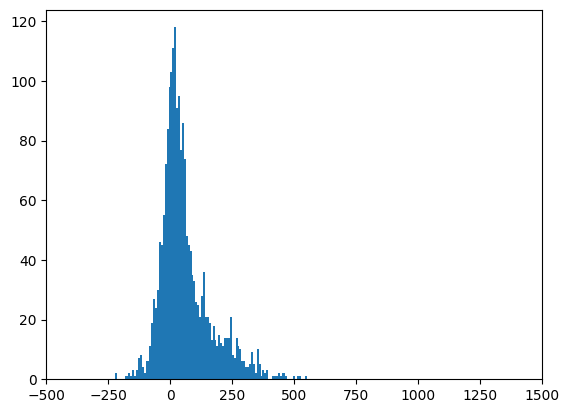

In [ ]:
pred = predictions[:,2]
pred = y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

plt.hist(pred, bins=100)
plt.xlim(-500, 1500)
plt.show()